In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler
from datetime import datetime
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    RobustScaler,
    PolynomialFeatures,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    make_scorer,
    recall_score,
    precision_score,
    f1_score,
)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    validation_curve,
    cross_val_score,
    StratifiedKFold,
)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

### Data prep

In [2]:
df = pd.read_csv(
    "DataForDecisionTree.csv",
    parse_dates=["program_start_date__c", "program_end_date__c", "date_of_birth__c"],
    dtype={"total_price": float, "discount_amount": float},
)
df

,id,currency__c,total_price,discount_amount,totalopportunityquantity,country_of_residence__c,date_of_birth__c,program_language__c,gender__c,your_industry__c,program_start_date__c,program_end_date__c,lob_category__c,program_code__c,current_annual_compensation_usd__c,utm_source__c,stagename
0,006RC00000BlCKLYA3,MXN,32500.0,0.0,1,Mexico,2006-07-13,Spanish,Male,Retail,2024-08-06,2024-10-01,GA Open Enrollment,OEP - ITA Marketing Analytics ESP GA,"Below USD 50,000",Google,Tuition fee pending
1,006RC00000BGNIUYA5,MXN,32500.0,0.0,1,Mexico,2000-07-10,Spanish,Male,Fast Moving Consumer Goods,2024-08-06,2024-10-01,GA Open Enrollment,OEP - ITA Marketing Analytics ESP GA,"Below USD 50,000",ppc,Tuition fee pending
2,006RC00000AKeWbYAL,MXN,32500.0,0.0,1,Mexico,1979-04-22,Spanish,Female,Advertising,2024-08-06,2024-10-01,GA Open Enrollment,OEP - ITA Marketing Analytics ESP GA,"Below USD 50,000",Facebook,Tuition fee pending
3,006RC00000BZ3JFYA1,MXN,32500.0,0.0,1,Mexico,2003-12-02,Spanish,Female,Retail,2024-08-06,2024-10-01,GA Open Enrollment,OEP - ITA Marketing Analytics ESP GA,"Below USD 50,000",Google,Tuition fee pending
4,006RC00000BS8AqYAL,MXN,32500.0,0.0,1,Mexico,1994-01-31,Spanish,Female,Retail,2024-08-06,2024-10-01,GA Open Enrollment,OEP - ITA Marketing Analytics ESP GA,"Below USD 50,000",Google,Tuition fee pending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17485,006RC000005xvfJYAQ,USD,850.0,0.0,1,Spain,1996-02-13,Spanish,Female,Human Resources Service Provider,2024-02-27,2024-04-28,GA Open Enrollment,OEP - MPE Cultural Awareness ESP GA,"USD 50,001 to USD 100,000",Web,Tuition fee pending
17486,006RC000009LbdhYAC,USD,850.0,0.0,1,Peru,2000-12-01,Spanish,Female,Education,2024-07-09,2024-08-13,GA Open Enrollment,OEP - MPE Cultural Awareness ESP GA,"Above USD 200,000",sales,Tuition fee pending
17487,006RC00000B84RVYAZ,USD,850.0,128.0,2,Puerto Rico,1982-10-17,Spanish,Male,Retail,2024-07-09,2024-08-13,GA Open Enrollment,OEP - MPE Cultural Awareness ESP GA,"USD 50,001 to USD 100,000",Web,Admission Granted
17488,006RC000009uZM6YAM,USD,850.0,0.0,1,Uruguay,1990-09-10,Spanish,Female,IT Products,2024-07-09,2024-08-13,GA Open Enrollment,OEP - MPE Cultural Awareness ESP GA,"USD 50,001 to USD 100,000",Web,Admission Granted


In [3]:
df.loc[:, "total_price"] = df.apply(
    lambda x: x["total_price"] * 1.1 if x["currency__c"] == "EUR" else x["total_price"],
    axis=1,
)
df.loc[:, "total_price"] = df.apply(
    lambda x: (
        x["total_price"] * 0.056
        if x["currency__c"] == "MXN" and x["total_price"] >= 30000
        else x["total_price"]
    ),
    axis=1,
)
df.loc[:, "total_price"] = df.apply(
    lambda x: (
        x["total_price"] * 0.00027 if x["currency__c"] == "COP" else x["total_price"]
    ),
    axis=1,
)
df.loc[:, "total_price"] = df.apply(
    lambda x: (
        x["total_price"] * 0.0011 if x["currency__c"] == "CLP" else x["total_price"]
    ),
    axis=1,
)
df.loc[:, "total_price"] = df.apply(
    lambda x: (
        x["total_price"] * 0.18
        if x["currency__c"] == "BRL" and x["total_price"] >= 4000
        else x["total_price"]
    ),
    axis=1,
)
df.loc[:, "discount_amount"] = df.apply(
    lambda x: (
        x["discount_amount"] * 1.1
        if x["currency__c"] == "EUR"
        else x["discount_amount"]
    ),
    axis=1,
)
df.loc[:, "discount_amount"] = df.apply(
    lambda x: (
        x["discount_amount"] * 0.0011
        if x["currency__c"] == "CLP"
        else x["discount_amount"]
    ),
    axis=1,
)
df.loc[:, "discount_amount"] = df.apply(
    lambda x: (
        x["discount_amount"] * 0.00027
        if x["currency__c"] == "COP"
        else x["discount_amount"]
    ),
    axis=1,
)
df.loc[:, "discount_amount"] = df.apply(
    lambda x: (
        x["discount_amount"] * 0.056
        if x["currency__c"] == "MXN"
        and (x["total_price"] >= 30000 or x["discount_amount"] >= x["total_price"])
        else x["discount_amount"]
    ),
    axis=1,
)
df.loc[:, "discount_amount"] = df.apply(
    lambda x: (
        x["discount_amount"] * 0.18
        if x["currency__c"] == "BRL"
        and (x["total_price"] >= 4000 or x["discount_amount"] >= x["total_price"])
        else x["discount_amount"]
    ),
    axis=1,
)

df.loc[:, "gender__c"] = df.apply(
    lambda x: ("Male" if x["gender__c"] == "Masculino" else x["gender__c"]),
    axis=1,
)
df.loc[:, "gender__c"] = df.apply(
    lambda x: ("Female" if x["gender__c"] == "Femenino" else x["gender__c"]),
    axis=1,
)
df.loc[:, "gender__c"] = df.apply(
    lambda x: (
        "Other"
        if x["gender__c"] == "Prefer not to say"
        or x["gender__c"] == "Prefer not to answer"
        or x["gender__c"] == "Non-Binary"
        or x["gender__c"] == "No binario"
        else x["gender__c"]
    ),
    axis=1,
)
df = df.query('gender__c != "Other"')
df = df.query('program_language__c != "French"')


df.loc[:, "lob_category__c"] = df.apply(
    lambda x: (
        "GA Open Enrollment"
        if x["lob_category__c"] == "GA Live Virtual"
        else x["lob_category__c"]
    ),
    axis=1,
)
df.loc[:, "lob_category__c"] = df.apply(
    lambda x: (
        "GA CXO or Certificate"
        if x["lob_category__c"] == "GA Certificate" or x["lob_category__c"] == "GA CXO"
        else x["lob_category__c"]
    ),
    axis=1,
)

df.loc[:, "total_price"] = df.loc[:, "total_price"].apply(
    lambda x: abs(x) if x < 0 else x
)
df.loc[:, "total_price"] = df.loc[:, "total_price"].apply(
    lambda x: df.query("total_price != 0").total_price.mean() if x == 0 else x
)

df.loc[:, "total_price"] = np.log1p(df.loc[:, "total_price"])
df.loc[:, "discount_amount"] = np.log1p(df.loc[:, "discount_amount"])

df.loc[:, "program_length"] = (
    df.loc[:, "program_end_date__c"] - df.loc[:, "program_start_date__c"]
).dt.days

df.loc[:, "age"] = round(
    (datetime.now() - df.loc[:, "date_of_birth__c"]).dt.total_seconds()
    / (365.25 * 24 * 60 * 60),
    0,
)

In [4]:
def clean_utm_source(x):
    if str(x).lower() in ["facebook", "instagram", "ig", "fb"]:
        return "Socials"
    elif str(x).lower() in ["linkedin", "lk-organic"]:
        return "Socials"
    elif str(x).lower() in ["google", "ppc"]:
        return "Web"
    elif str(x).lower() in ["school", "school_social", "boothexced", "mpe"]:
        return "School"
    elif str(x).lower() in ["template", "utm_source=template", "sales-template"]:
        return "Template"
    elif str(x).lower() in ["sales", "sales-whatsapp", "ga_b2b"]:
        return "Sales"
    elif str(x).lower() in ["inbound", "utm_source=inbound", "web"]:
        return "Web"
    else:
        return "Other"


df.loc[:, "utm_source__c"] = df.loc[:, "utm_source__c"].apply(clean_utm_source)

In [5]:
df.loc[:, "is_sale"] = df["stagename"].apply(
    lambda x: 1 if x == "Admission Granted" or x == "Suspended-Payment Overdue" else 0
)

In [6]:
country_to_region = {
    "United States": "North America",
    "Botswana": "Africa",
    "Virgin Islands, U.S.": "North America",
    "American Samoa": "ME&Oceania",
    "Yemen": "ME&Oceania",
    "Cayman Islands": "North America",
    "Brunei": "Asia",
    "Fiji": "ME&Oceania",
    "Maldives": "Asia",
    "Sri Lanka": "Asia",
    "Gambia": "Africa",
    "Myanmar": "Asia",
    "Gibraltar": "Europe",
    "Jersey": "North America",
    "Slovakia": "Europe",
    "Sierra Leone": "Africa",
    "Chad": "Africa",
    "Sudan": "Africa",
    "Angola": "Africa",
    "Namibia": "Africa",
    "Gabon": "Africa",
    "Lesotho": "Africa",
    "Swaziland": "Africa",
    "Mozambique": "Africa",
    "Zimbabwe": "Africa",
    "Tanzania": "Africa",
    "Rwanda": "Africa",
    "Burundi": "Africa",
    "Uganda": "Africa",
    "Ethiopia": "Africa",
    "Somalia": "Africa",
    "Djibouti": "Africa",
    "Eritrea": "Africa",
    "Seychelles": "Africa",
    "Madagascar": "Africa",
    "Mauritius": "Africa",
    "Comoros": "Africa",
    "Mayotte": "Africa",
    "Reunion": "Africa",
    "Zambia": "Africa",
    "Malawi": "Africa",
    "Mali": "Africa",
    "Niger": "Africa",
    "Nigeria": "Africa",
    "Ghana": "Africa",
    "Benin": "Africa",
    "Togo": "Africa",
    "Burkina Faso": "Africa",
    "Cote d'Ivoire": "Africa",
    "Guinea": "Africa",
    "Canada": "North America",
    "Mexico": "North America",
    "Brazil": "Latin America",
    "Argentina": "Latin America",
    "Chile": "Latin America",
    "Colombia": "Latin America",
    "Peru": "Latin America",
    "Venezuela": "Latin America",
    "Ecuador": "Latin America",
    "Bolivia": "Latin America",
    "Paraguay": "Latin America",
    "Uruguay": "Latin America",
    "Guyana": "Latin America",
    "Costa Rica": "Latin America",
    "El Salvador": "Latin America",
    "Guatemala": "Latin America",
    "Honduras": "Latin America",
    "Nicaragua": "Latin America",
    "Panama": "Latin America",
    "Puerto Rico": "Latin America",
    "Aruba": "Latin America",
    "Bahamas": "North America",
    "Dominican Republic": "Latin America",
    "Jamaica": "North America",
    "Turks and Caicos Islands": "North America",
    "United Kingdom": "Europe",
    "Germany": "Europe",
    "France": "Europe",
    "Italy": "Europe",
    "Spain": "Europe",
    "Portugal": "Europe",
    "Netherlands": "Europe",
    "Belgium": "Europe",
    "Switzerland": "Europe",
    "Austria": "Europe",
    "Denmark": "Europe",
    "Norway": "Europe",
    "Sweden": "Europe",
    "Finland": "Europe",
    "Ireland": "Europe",
    "Luxembourg": "Europe",
    "Czech Republic": "Europe",
    "Greece": "Europe",
    "Poland": "Europe",
    "Romania": "Europe",
    "Bulgaria": "Europe",
    "Hungary": "Europe",
    "Macedonia": "Europe",
    "Montenegro": "Europe",
    "Albania": "Europe",
    "Slovenia": "Europe",
    "Ukraine": "Europe",
    "Russia": "Europe",
    "Turkey": "Asia",
    "Armenia": "Asia",
    "Kazakhstan": "Asia",
    "Azerbaijan": "Asia",
    "Belarus": "Europe",
    "Monaco": "Europe",
    "Andorra": "Europe",
    "Malta": "Europe",
    "Australia": "ME&Oceania",
    "New Zealand": "ME&Oceania",
    "Mauritius": "ME&Oceania",
    "Israel": "ME&Oceania",
    "United Arab Emirates": "ME&Oceania",
    "Saudi Arabia": "ME&Oceania",
    "Qatar": "ME&Oceania",
    "Kuwait": "ME&Oceania",
    "Bahrain": "ME&Oceania",
    "Oman": "ME&Oceania",
    "Jordan": "ME&Oceania",
    "Palestinian Territory": "ME&Oceania",
    "Egypt": "Africa",
    "Algeria": "Africa",
    "Nigeria": "Africa",
    "South Africa": "Africa",
    "Kenya": "Africa",
    "Senegal": "Africa",
    "Zambia": "Africa",
    "Ghana": "Africa",
    "Uganda": "Africa",
    "Cameroon": "Africa",
    "China": "Asia",
    "Japan": "Asia",
    "India": "Asia",
    "South Korea": "Asia",
    "Indonesia": "Asia",
    "Thailand": "Asia",
    "Vietnam": "Asia",
    "Philippines": "Asia",
    "Malaysia": "Asia",
    "Singapore": "Asia",
    "Bangladesh": "Asia",
    "Pakistan": "Asia",
    "Cambodia": "Asia",
    "Hong Kong S.A.R., China": "Asia",
    "Macao S.A.R., China": "Asia",
    "Taiwan": "Asia",
    "Estonia": "Europe",
    "Lithuania": "Europe",
    "Cyprus": "Europe",
    "Guam": "ME&Oceania",
    "Bermuda": "North America",
    "French Guiana": "Latin America",
    "Morocco": "Africa",
    "Mongolia": "Asia",
    "Congo": "Africa",
    "Cuba": "Latin America",
    "Saint Lucia": "North America",
    "Tunisia": "Africa",
    "Uzbekistan": "Asia",
    "Haiti": "Latin America",
    "Trinidad and Tobago": "North America",
    "Iceland": "Europe",
    "Tonga": "ME&Oceania",
    "Latvia": "Europe",
    "Libya": "Africa",
    "Afghanistan": "Asia",
    "Georgia": "Asia",
    "Anguilla": "North America",
    "New Caledonia": "ME&Oceania",
    "Iran": "ME&Oceania",
    "Iraq": "ME&Oceania",
    "Serbia": "Europe",
    "Papua New Guinea": "ME&Oceania",
    "Syria": "ME&Oceania",
    "Lebanon": "ME&Oceania",
    "Nepal": "Asia",
}

df["Region"] = df["country_of_residence__c"].map(country_to_region)

In [7]:
industry_to_category = {
    "IT Services": "Technology",
    "IT Products": "Technology",
    "Electronics / Hardware": "Technology",
    "Tecnologías de la Información": "Technology",
    "Technology/Telecom": "Technology",
    "Telecommunications": "Technology",
    "Tecnología/Telecomunicaciones": "Technology",
    "Advertising": "Services",
    "Advertising/Marketing/PR": "Services",
    "Medios de comunicación/Publicidad": "Services",
    "Media": "Services",
    "Ecommerce": "Retail",
    "Retail": "Retail",
    "Productos de consumo/Retail": "Retail",
    "Consumer Products/Retail": "Retail",
    "Consulting": "Services",
    "Consultoría": "Services",
    "Servicios profesionales": "Services",
    "Professional Services": "Services",
    "Human Resources Service Provider": "Services",
    "Recursos Humanos/Reclutamiento": "Services",
    "Human Resources/Recruiting": "Services",
    "Banking & Financial Services": "Finance",
    "Financial Services": "Finance",
    "Banking": "Finance",
    "Bancario": "Finance",
    "Aseguradoras": "Finance",
    "Insurance": "Finance",
    "Servicios Financieros": "Finance",
    "Healthcare": "Other",
    "Cuidado de la salud/Servicios de salud": "Other",
    "Health Care/Health Services": "Other",
    "Biotechnology/Pharmaceuticals": "Other",
    "Biotecnología/Farmacéutica": "Other",
    "Education": "Education",
    "Educación": "Education",
    "Real Estate": "Services",
    "Real Estate/Development": "Services",
    "Desarrollo Inmobiliario": "Services",
    "Construcción": "Services",
    "Civil construction": "Services",
    "Manufacturing": "Industrial",
    "Manufactura": "Industrial",
    "Industrial Goods": "Industrial",
    "Ingeniería": "Industrial",
    "Engineering": "Industrial",
    "Energy": "Industrial",
    "Energy/Utilities": "Industrial",
    "Energía": "Industrial",
    "Agriculture": "Industrial",
    "Agricultura": "Industrial",
    "Medio ambiente": "Industrial",
    "Transport - Logistic": "Industrial",
    "Transportes/Logística": "Industrial",
    "Transportation/Logistics": "Industrial",
    "Aeroespacial/Aviación": "Aerospace & Defense",
    "Militar/Defensa": "Aerospace & Defense",
    "Nonprofit": "Other",
    "Sin fines de lucro": "Other",
    "Gobierno": "Other",
    "Leyes": "Other",
    "Accounting": "Finance",
    "Contabilidad y Contraloría": "Finance",
    "Otros": "Other",
    "Otro": "Other",
    "Others": "Other",
    "Other": "Other",
    "Entretenimiento/Hospitalidad/Ocio": "Services",
    "Tourism / Hotels / Restaurant": "Services",
    "Fast Moving Consumer Goods": "Retail",
    "Mercadeo/Comunicaciones/Relaciones Públicas": "Services",
    "IT/Computers": "Technology",
    # Add more mappings as needed
}
# Map the 'Industry' column to a new 'Category' column
df["Industry"] = df["your_industry__c"].map(industry_to_category)

In [8]:
# # Function to frequency encode specified columns to avoid multicollinearity and reduce dimensionality
# def frequency_encode(df, columns):
#     for col in columns:
#         freq = df[col].value_counts()
#         df[col] = df[col].map(freq)


# # Apply frequency encoding
# freq_encode_cols = ["program_code__c"]
# frequency_encode(df, freq_encode_cols)

value_counts = df.program_code__c.value_counts(normalize=True)

df.loc[:, "program_code__c"] = df["program_code__c"].map(value_counts)

df["program_code__c"] = df["program_code__c"].astype(float)

df = df.rename(columns={"program_code__c": "program_popularity"})

In [9]:
df["discount_ratio"] = df["discount_amount"] / df["total_price"]

In [10]:
# Function to create synthetic data points by shuffling categorical features and perturbing numerical features
def create_synthetic_data(
    df,
    features_to_shuffle,
    numerical_features_to_perturb,
    n_samples,
    perturbation_std=0.1,
):
    synthetic_data = []
    original_columns = df.columns.tolist()

    for _ in range(n_samples):
        # Randomly select a row index to start with
        row_index = np.random.choice(df.index)

        # Shuffle the specified features and perturb the numerical features
        new_data_point = {}
        for feature in original_columns:
            if feature in features_to_shuffle:
                # Shuffle categorical feature
                shuffled_value = np.random.choice(df[feature].values)
                new_data_point[feature] = shuffled_value
            elif feature in numerical_features_to_perturb:
                # Perturb numerical feature
                original_value = df.at[row_index, feature]
                perturbed_value = original_value + np.random.normal(0, perturbation_std)
                new_data_point[feature] = perturbed_value
            else:
                # Keep the original value for other features
                new_data_point[feature] = df.at[row_index, feature]

        synthetic_data.append(new_data_point)

    return pd.DataFrame(synthetic_data)


# Specify the list of features to shuffle
features_to_shuffle = [
    "current_annual_compensation_usd__c",
    "utm_source__c",
    "Region",
    "Industry",
    "program_language__c",
    "gender__c",
]

numerical_features_to_perturb = [
    "discount_ratio",
    "program_popularity",
    "total_price",
    "discount_amount",
    "program_length",
    "age",
]

# Create synthetic data by shuffling and combining features
n_samples = 1000  # Number of new data points to create
synthetic_df = create_synthetic_data(
    df,
    features_to_shuffle,
    numerical_features_to_perturb,
    n_samples,
    perturbation_std=0.01,
)

# Combine the original and synthetic data
augmented_df = pd.concat([df, synthetic_df], ignore_index=True)

In [11]:
model_df = augmented_df.drop(
    columns=[
        "program_start_date__c",
        "program_end_date__c",
        "date_of_birth__c",
        "stagename",
        "currency__c",
        "country_of_residence__c",
        "your_industry__c",
        "id",
        # "discount_amount",
        # "total_price",
        # "lob_category__c",
        # "program_length",
        # "age",
        # 'program_language__c',
        # "utm_source__c",
        # "Region",
        # "Industry",
        # "discount_ratio",
        # "totalopportunityquantity",
        # "gender__c",
        # "program_popularity",
        # "current_anual_compensation_usd__c",
    ]
)

In [12]:
model_df.describe(include="all")

,total_price,discount_amount,totalopportunityquantity,program_language__c,gender__c,lob_category__c,program_popularity,current_annual_compensation_usd__c,utm_source__c,program_length,age,is_sale,Region,Industry,discount_ratio
count,18278.000000,18278.000000,18278.000000,18278,18278,18278,18278.000000,18278,18278,18278.000000,18278.000000,18278.000000,18278,18278,18278.000000
unique,NaN,NaN,NaN,3,2,2,NaN,5,6,NaN,NaN,NaN,6,7,NaN
top,NaN,NaN,NaN,English,Male,GA Open Enrollment,NaN,"Below USD 50,000",Web,NaN,NaN,NaN,North America,Other,NaN
freq,NaN,NaN,NaN,10500,10960,18236,NaN,6630,8895,NaN,NaN,NaN,8780,4556,NaN
mean,7.764669,0.661831,1.138801,NaN,NaN,NaN,0.032755,NaN,NaN,50.837187,41.005277,0.367655,NaN,NaN,0.085395
std,0.309015,1.822051,0.355885,NaN,NaN,NaN,0.051519,NaN,NaN,16.082443,10.250290,0.482180,NaN,NaN,0.234966
min,6.739349,-0.030300,0.000000,NaN,NaN,NaN,-0.028007,NaN,NaN,13.984554,17.989149,0.000000,NaN,NaN,-0.033170
25%,7.534228,0.000000,1.000000,NaN,NaN,NaN,0.006135,NaN,NaN,55.000000,34.000000,0.000000,NaN,NaN,0.000000
50%,7.824446,0.000000,1.000000,NaN,NaN,NaN,0.011470,NaN,NaN,56.000000,41.000000,0.000000,NaN,NaN,0.000000
75%,8.047510,0.000000,1.000000,NaN,NaN,NaN,0.019968,NaN,NaN,61.000000,48.000000,1.000000,NaN,NaN,0.000000


### Data encoding and tensor declaration

In [68]:
# Features and target variable
X = model_df.drop("is_sale", axis=1)
y = model_df["is_sale"]

categorical_cols = X.select_dtypes(include=["object"]).columns
numerical_cols = X.select_dtypes(include=["number"]).columns

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("robust", RobustScaler()),
        ("scaler", MinMaxScaler()),
        ("poly", PolynomialFeatures(degree=2, interaction_only=True)),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

smote = SMOTE(sampling_strategy="minority", random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

# Convert to PyTorch tensors

X_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_tensor = torch.tensor(y_resampled.values, dtype=torch.float32).unsqueeze(1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.10, random_state=42
)

# Create DataLoader for PyTorch
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [41]:
X_train.shape

torch.Size([20804, 60])

In [82]:
# Simple feedforward neural network
class SimpleFNN(nn.Module):
    def __init__(self):
        super(SimpleFNN, self).__init__()
        self.fc1 = nn.Linear(60, 32)  # 2 input features, 8 hidden units
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 16)
        self.dropout3 = nn.Dropout(0.2)
        # self.fc4 = nn.Linear(32, 16)
        # self.dropout4 = nn.Dropout(0.2)
        # self.fc5 = nn.Linear(16, 8)
        # self.dropout5 = nn.Dropout(0.2)
        self.fc6 = nn.Linear(16, 1)  # 1 output unit (binary classification)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        # x = torch.relu(self.fc4(x))
        # x = self.dropout4(x)
        # x = torch.relu(self.fc5(x))
        # x = self.dropout5(x)
        x = self.fc6(x)
        x = self.sigmoid(x)
        return x


class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): How long to wait after last time the validation loss improved.
                            Default: 5
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                                Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


# Set seed for reproducibility
torch.manual_seed(42)

# Model, loss function, and optimizer
model = SimpleFNN()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.001, momentum=0.8)
# optimizer = optim.Adagrad(model.parameters(), lr=0.01, weight_decay=0.001))

# Learning rate scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.6, patience=10
)

# Early stopping parameters
early_stopping = EarlyStopping(patience=40, min_delta=0.0001)

# Training loop
num_epochs = 500
final_epoch = 0
for epoch in range(num_epochs):  # Number of epochs
    model.train()
    train_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        train_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Average losses
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)

    print(
        f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}"
    )

    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        final_epoch = epoch + 1
        break

    # Update learning rate
    scheduler.step(val_loss)

# After training, you can make predictions with:
# predictions = model(X)

Epoch 1/500, Training Loss: 0.6355, Validation Loss: 0.5692
Epoch 2/500, Training Loss: 0.5795, Validation Loss: 0.5593
Epoch 3/500, Training Loss: 0.5701, Validation Loss: 0.5550
Epoch 4/500, Training Loss: 0.5656, Validation Loss: 0.5534
Epoch 5/500, Training Loss: 0.5645, Validation Loss: 0.5526
Epoch 6/500, Training Loss: 0.5647, Validation Loss: 0.5525
Epoch 7/500, Training Loss: 0.5640, Validation Loss: 0.5520
Epoch 8/500, Training Loss: 0.5588, Validation Loss: 0.5503
Epoch 9/500, Training Loss: 0.5599, Validation Loss: 0.5470
Epoch 10/500, Training Loss: 0.5592, Validation Loss: 0.5490
Epoch 11/500, Training Loss: 0.5572, Validation Loss: 0.5482
Epoch 12/500, Training Loss: 0.5582, Validation Loss: 0.5473
Epoch 13/500, Training Loss: 0.5567, Validation Loss: 0.5462
Epoch 14/500, Training Loss: 0.5557, Validation Loss: 0.5470
Epoch 15/500, Training Loss: 0.5553, Validation Loss: 0.5448
Epoch 16/500, Training Loss: 0.5532, Validation Loss: 0.5440
Epoch 17/500, Training Loss: 0.55

In [83]:
# Set the model to evaluation mode
model.eval()

# No gradient computation needed during evaluation
with torch.no_grad():
    y_pred_probs = model(X_test)  # Get model predictions (probabilities)
    y_pred = (y_pred_probs > 0.5).float()  # Convert probabilities to binary (0 or 1)

# Convert tensors to numpy arrays for sklearn functions
y_test_np = y_test.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()

# Calculate evaluation metrics
print("Accuracy: ", accuracy_score(y_test_np, y_pred_np))
print("Recall: ", recall_score(y_test_np, y_pred_np))
print("Precision: ", precision_score(y_test_np, y_pred_np))
print("F1: ", f1_score(y_test_np, y_pred_np))

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_np)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(y_test_np, y_pred_np, target_names=["Class 0", "Class 1"])
print("\nClassification Report:")
print(cr)

Accuracy:  0.7166955017301038
Recall:  0.6983289357959542
Precision:  0.7179023508137432
F1:  0.7079803834150691

Confusion Matrix:
[[863 312]
 [343 794]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.72      0.73      0.72      1175
     Class 1       0.72      0.70      0.71      1137

    accuracy                           0.72      2312
   macro avg       0.72      0.72      0.72      2312
weighted avg       0.72      0.72      0.72      2312



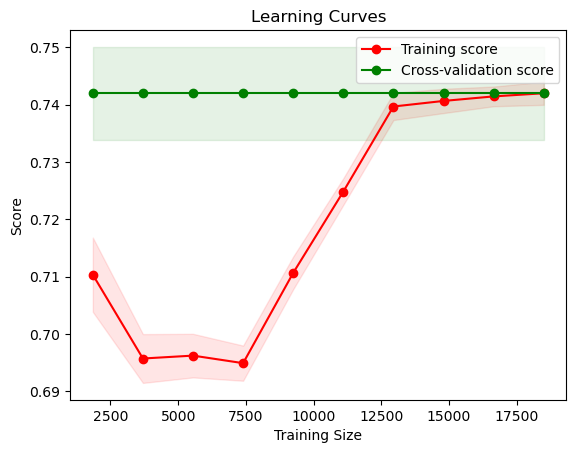

In [84]:
class EstimatorWrapper(BaseEstimator):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # Convert numpy arrays to PyTorch tensors if needed
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

        self.model.train()

        num_epochs = final_epoch
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            outputs = self.model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

    def predict(self, X):
        self.model.eval()
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X)
            predictions = (outputs > 0.5).float()
        return predictions.numpy().flatten()  # Convert to numpy array


# Assuming 'model' is your PyTorch model, already defined
estimator = EstimatorWrapper(model)

# Stratified K-Folds cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Learning curve generation
train_sizes, train_scores, val_scores = learning_curve(
    estimator,
    X_tensor.numpy(),  # Ensure these are numpy arrays
    y_tensor.numpy().flatten(),  # Flatten y to match sklearn's expectation
    cv=skf,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 10),
)

# Calculate mean and standard deviation for the learning curves
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure()
plt.plot(train_sizes, train_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, val_mean, "o-", color="g", label="Cross-validation score")
plt.fill_between(
    train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r"
)
plt.fill_between(
    train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g"
)
plt.xlabel("Training Size")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curves")
plt.show()

In [85]:
torch.save(model.state_dict(), "dl_model.pth")